In [4]:
library(tidyverse)
library(ggplot2)
library(data.table)
library(ggrepel)
library(UpSetR)
library(vroom)
library(rmeta)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘data.table’


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose



Attaching package: ‘vroom’


The following objects are masked

In [5]:
# This is only needed for motif disruption plots, and only some for actual plotting
library(motifbreakR)
suppressPackageStartupMessages(library(MotifDb))
suppressPackageStartupMessages(library(BSgenome))
suppressPackageStartupMessages(library("BSgenome.Hsapiens.UCSC.hg38"))
library(parallel)
library(qvalue)

Loading required package: grid

Loading required package: MotifDb

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors

Loading required package: stats4


Attaching package: ‘S4Vectors’


The following objec

### Run this first

In [4]:
cell_types <- c('acinar','alpha','beta','bulk','delta','ductal','endothelial','gamma','immune','stellate')

In [5]:
cell_types_tested <- c('acinar','alpha','beta','bulk','delta','ductal','gamma')

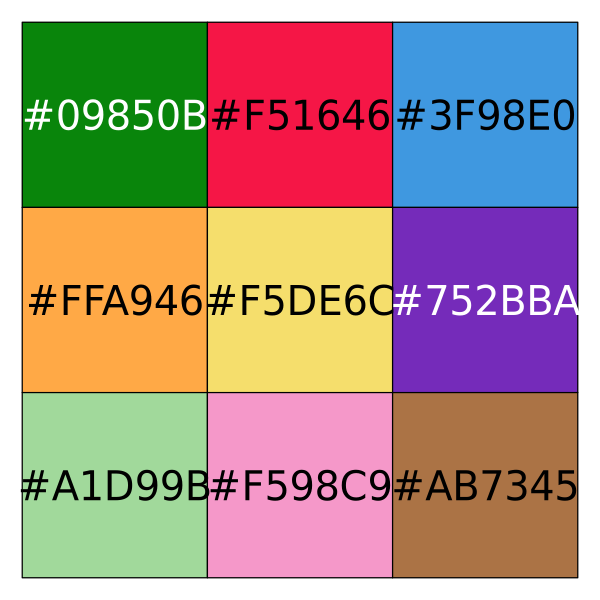

In [6]:
major_colors = c('acinar'='#09850B', 'alpha'='#F51646', 'beta'='#3F98E0',
                 'delta'='#FFA946', 'ductal'='#F5DE6C', 'endothelial'='#752BBA', 
                 'gamma'='#A1D99B', 'immune'='#F598C9', 'stellate'='#AB7345')
options(repr.plot.width=5, repr.plot.height=5)
scales::show_col(major_colors, cex_label=2)

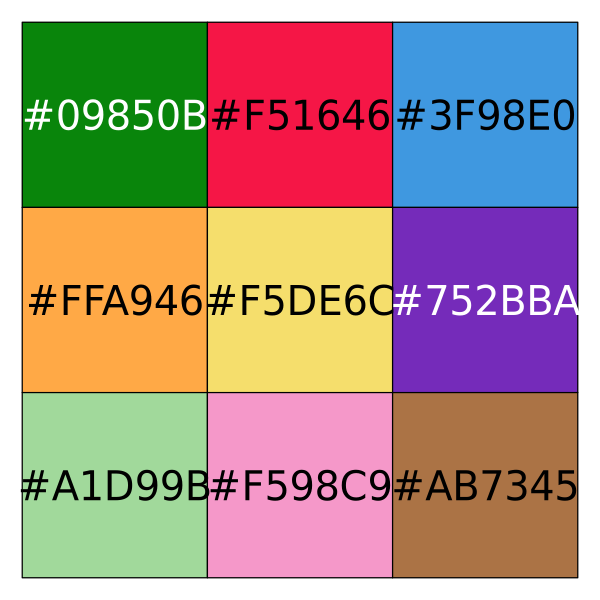

In [7]:
major_colors_caps = c('Acinar'='#09850B', 'Alpha'='#F51646', 'Beta'='#3F98E0',
                 'Delta'='#FFA946', 'Ductal'='#F5DE6C', 'Endothelial'='#752BBA', 
                 'Gamma'='#A1D99B', 'Immune'='#F598C9', 'Stellate'='#AB7345')
options(repr.plot.width=5, repr.plot.height=5)
scales::show_col(major_colors_caps, cex_label=2)

In [8]:
fig_dir <- '/path/to/caQTL/stuff/figures/'

# Lead Variant Peak Overlap

In [9]:
intermediates.dir <- '/path/to/caQTL/stuff/figures/lead_variant_peak_overlap/'
full_peaks <- '/path/to/peaks/recluster_final_majorCTs_v2/mergedPeak.txt'

In [9]:
# Intersect lead variants with peaks and add to caQTL summary stats

summarised_data <- data.frame()
for (c in cell_types_tested) {
    leads <- vroom(paste0('/path/to/caQTL/stuff/caQTLs_rasqual/',c,'/run1/Results_run1F_lead.tsv'))
    #leads <- filter(leads, flag_fdr05)
    
    snp.bed <- data.frame(str_split(leads$rsID, ":", simplify=T)[,1:2])
    colnames(snp.bed) <- c('Chromosome','Start')
    snp.bed$Start <- as.numeric(snp.bed$Start)
    snp.bed$End <- snp.bed$Start
    snp.bed$Start <- snp.bed$Start - 1
    snp.bed$rsID <- leads$rsID
    snp.bed <- distinct(snp.bed)
    
    write.table(snp.bed, paste0(intermediates.dir, c, '_lead_variants.bed'), quote=F, row.names=F, col.names=F, sep='\t')
    
    system(paste0("bedtools intersect -a ", intermediates.dir,
                  c, '_lead_variants.bed -b ', full_peaks,
              ' -wa -wb -loj > ', intermediates.dir, c, '_lead_intersected_variants.bed'))
    
    intersect <- read.table(paste0( intermediates.dir, c, '_lead_intersected_variants.bed'),
           sep='\t', header=F, col.names=c('Variant.Chr','Variant.Start','Variant.Pos', 'rsID','Peak.Chr','Peak.Start','Peak.End'))
    intersect$In.Feature <- paste0(intersect$Peak.Chr, ":", intersect$Peak.Start, "-", intersect$Peak.End)
    intersect[intersect$Peak.Start == -1,]$In.Feature <- NA
    intersect <- select(intersect, rsID, In.Feature)
    
    leads.intersect <- left_join(leads, intersect)
    leads.intersect$Peak.Intersect.State <- "In.Other.Peak"
    leads.intersect[is.na(leads.intersect$In.Feature),]$Peak.Intersect.State <- 'Not.In.Peak'
    leads.intersect[!is.na(leads.intersect$In.Feature),][(leads.intersect[!is.na(leads.intersect$In.Feature),]$Feature == leads.intersect[!is.na(leads.intersect$In.Feature),]$In.Feature),]$Peak.Intersect.State <- 'In.caQTL.Peak'
    
    write.table(leads.intersect, paste0(intermediates.dir, c, '_lead_sum_stats_run1F_intersect_flag.tsv'), 
                quote=F, row.names=F, col.names=T, sep='\t')
    
    ct_count <- pivot_wider(data.frame(table(leads.intersect$Peak.Intersect.State)), values_from = Freq, names_from = Var1)
    ct_count <- select(ct_count, In.caQTL.Peak, In.Other.Peak, Not.In.Peak)
    ct_count$cell <- c

    summarised_data <- rbind(summarised_data, ct_count)
    
    print(c)
    print(table(leads.intersect$Peak.Intersect.State))
}

summarised_data

write.table(summarised_data, paste0(intermediates.dir, 'run1F_lead_intersect_flag_counts_by_ct.tsv'), 
                quote=F, row.names=F, col.names=T, sep='\t')

Rows: 96373 Columns: 30
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (5): Feature, rsID, Chromosome, Ref, Alt
dbl (22): position, Af, HWEChi_square, IA, Log10_qval, Chi_square, Effect_si...
lgl  (3): flag_fdr10, flag_fdr05, flag_fdr01

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(rsID)`


[1] "acinar"

In.caQTL.Peak In.Other.Peak   Not.In.Peak 
         9572          8790         78011 


Rows: 107935 Columns: 30
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (5): Feature, rsID, Chromosome, Ref, Alt
dbl (22): position, Af, HWEChi_square, IA, Log10_qval, Chi_square, Effect_si...
lgl  (3): flag_fdr10, flag_fdr05, flag_fdr01

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(rsID)`


[1] "alpha"

In.caQTL.Peak In.Other.Peak   Not.In.Peak 
        11391          9557         86987 


Rows: 106506 Columns: 30
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (5): Feature, rsID, Chromosome, Ref, Alt
dbl (22): position, Af, HWEChi_square, IA, Log10_qval, Chi_square, Effect_si...
lgl  (3): flag_fdr10, flag_fdr05, flag_fdr01

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(rsID)`


[1] "beta"

In.caQTL.Peak In.Other.Peak   Not.In.Peak 
        12508          9302         84696 


Rows: 252057 Columns: 30
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (5): Feature, rsID, Chromosome, Ref, Alt
dbl (22): position, Af, HWEChi_square, IA, Log10_qval, Chi_square, Effect_si...
lgl  (3): flag_fdr10, flag_fdr05, flag_fdr01

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(rsID)`


[1] "bulk"

In.caQTL.Peak In.Other.Peak   Not.In.Peak 
        22436         22523        207098 


Rows: 79636 Columns: 30
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (5): Feature, rsID, Chromosome, Ref, Alt
dbl (22): position, Af, HWEChi_square, IA, Log10_qval, Chi_square, Effect_si...
lgl  (3): flag_fdr10, flag_fdr05, flag_fdr01

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(rsID)`


[1] "delta"

In.caQTL.Peak In.Other.Peak   Not.In.Peak 
         8082          7585         63969 


Rows: 49135 Columns: 30
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (5): Feature, rsID, Chromosome, Ref, Alt
dbl (22): position, Af, HWEChi_square, IA, Log10_qval, Chi_square, Effect_si...
lgl  (3): flag_fdr10, flag_fdr05, flag_fdr01

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(rsID)`


[1] "ductal"

In.caQTL.Peak In.Other.Peak   Not.In.Peak 
         5073          4769         39293 


Rows: 60138 Columns: 30
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (5): Feature, rsID, Chromosome, Ref, Alt
dbl (22): position, Af, HWEChi_square, IA, Log10_qval, Chi_square, Effect_si...
lgl  (3): flag_fdr10, flag_fdr05, flag_fdr01

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(rsID)`


[1] "gamma"

In.caQTL.Peak In.Other.Peak   Not.In.Peak 
         6297          5844         47997 


In.caQTL.Peak,In.Other.Peak,Not.In.Peak,cell
<int>,<int>,<int>,<chr>
9572,8790,78011,acinar
11391,9557,86987,alpha
12508,9302,84696,beta
22436,22523,207098,bulk
8082,7585,63969,delta
5073,4769,39293,ductal
6297,5844,47997,gamma


In [10]:
# Intersect all variants with peaks and add to caQTL summary stats
summarised_data <- data.frame()
for (c in cell_types_tested) {
    all <- vroom(paste0('/path/to/caQTL/stuff/caQTLs_rasqual/',c,'/run1/Results_run1F_all.tsv'))
    #all <- filter(all, flag_fdr05)
    
    snp.bed <- data.frame(str_split(all$rsID, ":", simplify=T)[,1:2])
    colnames(snp.bed) <- c('Chromosome','Start')
    snp.bed$Start <- as.numeric(snp.bed$Start)
    snp.bed$End <- snp.bed$Start
    snp.bed$Start <- snp.bed$Start - 1
    snp.bed$rsID <- all$rsID
    snp.bed <- distinct(snp.bed)
    
    write.table(snp.bed, paste0(intermediates.dir, c, '_all_variants.bed'), quote=F, row.names=F, col.names=F, sep='\t')
    
    system(paste0("bedtools intersect -a ", intermediates.dir,
                  c, '_all_variants.bed -b ', full_peaks,
              ' -wa -wb -loj > ', intermediates.dir, c, '_all_intersected_variants.bed'))
    
    intersect <- read.table(paste0( intermediates.dir, c, '_all_intersected_variants.bed'),
           sep='\t', header=F, col.names=c('Variant.Chr','Variant.Start','Variant.Pos', 'rsID','Peak.Chr','Peak.Start','Peak.End'))
    intersect$In.Feature <- paste0(intersect$Peak.Chr, ":", intersect$Peak.Start, "-", intersect$Peak.End)
    intersect[intersect$Peak.Start == -1,]$In.Feature <- NA
    intersect <- select(intersect, rsID, In.Feature)
    
    all.intersect <- left_join(all, intersect)
    all.intersect$Peak.Intersect.State <- "In.Other.Peak"
    all.intersect[is.na(all.intersect$In.Feature),]$Peak.Intersect.State <- 'Not.In.Peak'
    all.intersect[!is.na(all.intersect$In.Feature),][(all.intersect[!is.na(all.intersect$In.Feature),]$Feature == all.intersect[!is.na(all.intersect$In.Feature),]$In.Feature),]$Peak.Intersect.State <- 'In.caQTL.Peak'
    
    write.table(all.intersect, paste0(intermediates.dir, c, '_all_sum_stats_run1F_intersect_flag.tsv'), 
                quote=F, row.names=F, col.names=T, sep='\t')
    
    ct_count <- pivot_wider(data.frame(table(all.intersect$Peak.Intersect.State)), values_from = Freq, names_from = Var1)
    ct_count <- select(ct_count, In.caQTL.Peak, In.Other.Peak, Not.In.Peak)
    ct_count$cell <- c

    summarised_data <- rbind(summarised_data, ct_count)
    
    print(c)
    print(table(all.intersect$Peak.Intersect.State))
}

summarised_data

write.table(summarised_data, paste0(intermediates.dir, 'run1F_all_intersect_flag_counts_by_ct.tsv'), 
                quote=F, row.names=F, col.names=T, sep='\t')

Rows: 4388313 Columns: 30
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (5): Feature, rsID, Chromosome, Ref, Alt
dbl (22): position, Af, HWEChi_square, IA, Log10_qval, Chi_square, Effect_si...
lgl  (3): flag_fdr10, flag_fdr05, flag_fdr01

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(rsID)`


[1] "acinar"

In.caQTL.Peak In.Other.Peak   Not.In.Peak 
       183100        395319       3809894 


Rows: 4863251 Columns: 30
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (5): Feature, rsID, Chromosome, Ref, Alt
dbl (22): position, Af, HWEChi_square, IA, Log10_qval, Chi_square, Effect_si...
lgl  (3): flag_fdr10, flag_fdr05, flag_fdr01

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(rsID)`


[1] "alpha"

In.caQTL.Peak In.Other.Peak   Not.In.Peak 
       200523        432637       4230091 


Rows: 4797279 Columns: 30
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (5): Feature, rsID, Chromosome, Ref, Alt
dbl (22): position, Af, HWEChi_square, IA, Log10_qval, Chi_square, Effect_si...
lgl  (3): flag_fdr10, flag_fdr05, flag_fdr01

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(rsID)`


[1] "beta"

In.caQTL.Peak In.Other.Peak   Not.In.Peak 
       197631        419308       4180340 


Rows: 11523909 Columns: 30
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (5): Feature, rsID, Chromosome, Ref, Alt
dbl (22): position, Af, HWEChi_square, IA, Log10_qval, Chi_square, Effect_si...
lgl  (3): flag_fdr10, flag_fdr05, flag_fdr01

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(rsID)`


[1] "bulk"

In.caQTL.Peak In.Other.Peak   Not.In.Peak 
       349079       1004419      10170411 


Rows: 3556559 Columns: 30
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (5): Feature, rsID, Chromosome, Ref, Alt
dbl (22): position, Af, HWEChi_square, IA, Log10_qval, Chi_square, Effect_si...
lgl  (3): flag_fdr10, flag_fdr05, flag_fdr01

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(rsID)`


[1] "delta"

In.caQTL.Peak In.Other.Peak   Not.In.Peak 
       171763        331519       3053277 


Rows: 2238072 Columns: 30
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (5): Feature, rsID, Chromosome, Ref, Alt
dbl (22): position, Af, HWEChi_square, IA, Log10_qval, Chi_square, Effect_si...
lgl  (3): flag_fdr10, flag_fdr05, flag_fdr01

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(rsID)`


[1] "ductal"

In.caQTL.Peak In.Other.Peak   Not.In.Peak 
       119248        218942       1899882 


Rows: 2665243 Columns: 30
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (5): Feature, rsID, Chromosome, Ref, Alt
dbl (22): position, Af, HWEChi_square, IA, Log10_qval, Chi_square, Effect_si...
lgl  (3): flag_fdr10, flag_fdr05, flag_fdr01

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(rsID)`


[1] "gamma"

In.caQTL.Peak In.Other.Peak   Not.In.Peak 
       140024        257914       2267305 


In.caQTL.Peak,In.Other.Peak,Not.In.Peak,cell
<int>,<int>,<int>,<chr>
183100,395319,3809894,acinar
200523,432637,4230091,alpha
197631,419308,4180340,beta
349079,1004419,10170411,bulk
171763,331519,3053277,delta
119248,218942,1899882,ductal
140024,257914,2267305,gamma


In [109]:
# Summarise by feature
for (c in cell_types_tested) {
    #All
    all.intersect <- vroom(paste0(intermediates.dir, c, '_all_sum_stats_run1F_intersect_flag.tsv'))
    
    all.intersect$flag_NotInPeak <- all.intersect$Peak.Intersect.State == 'Not.In.Peak'
    all.intersect$flag_InPeak <- all.intersect$Peak.Intersect.State == 'In.caQTL.Peak'
    
    all.intersect.Feat <- all.intersect %>%
        filter(flag_fdr05) %>%
        select(Feature, In.Feature, Peak.Intersect.State, flag_InPeak, flag_NotInPeak) %>%
        group_by(Feature) %>%
        summarise(flag_NotInPeak=all(flag_NotInPeak), flag_InPeak=any(flag_InPeak))
    
    write.table(all.intersect.Feat, paste0(intermediates.dir, c, '_all_sum_stats_run1F_intersect_flag_by_feature.tsv'), 
                quote=F, row.names=F, col.names=T, sep='\t')
    
    #Leads
    lead.intersect <- vroom(paste0(intermediates.dir, c, '_lead_sum_stats_run1F_intersect_flag.tsv'))
    
    lead.intersect$flag_NotInPeak <- lead.intersect$Peak.Intersect.State == 'Not.In.Peak'
    lead.intersect$flag_InPeak <- lead.intersect$Peak.Intersect.State == 'In.caQTL.Peak'
    
    lead.intersect.Feat <- lead.intersect %>%
        filter(flag_fdr05) %>%
        select(Feature, In.Feature, Peak.Intersect.State, flag_InPeak, flag_NotInPeak) %>%
        group_by(Feature) %>%
        summarise(flag_NotInPeak=all(flag_NotInPeak), flag_InPeak=any(flag_InPeak))
    
    write.table(lead.intersect.Feat, paste0(intermediates.dir, c, '_lead_sum_stats_run1F_intersect_flag_by_feature.tsv'), 
                quote=F, row.names=F, col.names=T, sep='\t')
    
    print(c)
    select(all.intersect.Feat, -Feature) %>%
          table() %>%
          print()
    
    select(lead.intersect.Feat, -Feature) %>%
          table() %>%
          print()
}

Rows: 4388313 Columns: 32
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (7): Feature, rsID, Chromosome, Ref, Alt, In.Feature, Peak.Intersect.State
dbl (22): position, Af, HWEChi_square, IA, Log10_qval, Chi_square, Effect_si...
lgl  (3): flag_fdr10, flag_fdr05, flag_fdr01

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 96373 Columns: 32
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (7): Feature, rsID, Chromosome, Ref, Alt, In.Feature, Peak.Intersect.State
dbl (22): position, Af, HWEChi_square, IA, Log10_qval, Chi_square, Effect_si...
lgl  (3): flag_fdr10, flag_fdr05, flag_fdr01

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `sho

[1] "acinar"
              flag_InPeak
flag_NotInPeak FALSE TRUE
         FALSE   126 1876
         TRUE    142    0
              flag_InPeak
flag_NotInPeak FALSE TRUE
         FALSE   137  878
         TRUE   1129    0


Rows: 4863251 Columns: 32
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (7): Feature, rsID, Chromosome, Ref, Alt, In.Feature, Peak.Intersect.State
dbl (22): position, Af, HWEChi_square, IA, Log10_qval, Chi_square, Effect_si...
lgl  (3): flag_fdr10, flag_fdr05, flag_fdr01

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 107935 Columns: 32
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (7): Feature, rsID, Chromosome, Ref, Alt, In.Feature, Peak.Intersect.State
dbl (22): position, Af, HWEChi_square, IA, Log10_qval, Chi_square, Effect_si...
lgl  (3): flag_fdr10, flag_fdr05, flag_fdr01

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `sh

[1] "alpha"
              flag_InPeak
flag_NotInPeak FALSE TRUE
         FALSE   273 3646
         TRUE    299    0
              flag_InPeak
flag_NotInPeak FALSE TRUE
         FALSE   262 1751
         TRUE   2205    0


Rows: 4797279 Columns: 32
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (7): Feature, rsID, Chromosome, Ref, Alt, In.Feature, Peak.Intersect.State
dbl (22): position, Af, HWEChi_square, IA, Log10_qval, Chi_square, Effect_si...
lgl  (3): flag_fdr10, flag_fdr05, flag_fdr01

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 106506 Columns: 32
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (7): Feature, rsID, Chromosome, Ref, Alt, In.Feature, Peak.Intersect.State
dbl (22): position, Af, HWEChi_square, IA, Log10_qval, Chi_square, Effect_si...
lgl  (3): flag_fdr10, flag_fdr05, flag_fdr01

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `sh

[1] "beta"
              flag_InPeak
flag_NotInPeak FALSE TRUE
         FALSE   381 5148
         TRUE    403    0
              flag_InPeak
flag_NotInPeak FALSE TRUE
         FALSE   343 2563
         TRUE   3026    0


Rows: 11523909 Columns: 32
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (7): Feature, rsID, Chromosome, Ref, Alt, In.Feature, Peak.Intersect.State
dbl (22): position, Af, HWEChi_square, IA, Log10_qval, Chi_square, Effect_si...
lgl  (3): flag_fdr10, flag_fdr05, flag_fdr01

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 252057 Columns: 32
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (7): Feature, rsID, Chromosome, Ref, Alt, In.Feature, Peak.Intersect.State
dbl (22): position, Af, HWEChi_square, IA, Log10_qval, Chi_square, Effect_si...
lgl  (3): flag_fdr10, flag_fdr05, flag_fdr01

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `s

[1] "bulk"
              flag_InPeak
flag_NotInPeak FALSE  TRUE
         FALSE   894 10434
         TRUE    889     0
              flag_InPeak
flag_NotInPeak FALSE TRUE
         FALSE   767 5016
         TRUE   6434    0


Rows: 3556559 Columns: 32
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (7): Feature, rsID, Chromosome, Ref, Alt, In.Feature, Peak.Intersect.State
dbl (22): position, Af, HWEChi_square, IA, Log10_qval, Chi_square, Effect_si...
lgl  (3): flag_fdr10, flag_fdr05, flag_fdr01

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 79636 Columns: 32
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (7): Feature, rsID, Chromosome, Ref, Alt, In.Feature, Peak.Intersect.State
dbl (22): position, Af, HWEChi_square, IA, Log10_qval, Chi_square, Effect_si...
lgl  (3): flag_fdr10, flag_fdr05, flag_fdr01

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `sho

[1] "delta"
              flag_InPeak
flag_NotInPeak FALSE TRUE
         FALSE    50  758
         TRUE     69    0
              flag_InPeak
flag_NotInPeak FALSE TRUE
         FALSE    43  349
         TRUE    485    0


Rows: 2238072 Columns: 32
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (7): Feature, rsID, Chromosome, Ref, Alt, In.Feature, Peak.Intersect.State
dbl (22): position, Af, HWEChi_square, IA, Log10_qval, Chi_square, Effect_si...
lgl  (3): flag_fdr10, flag_fdr05, flag_fdr01

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 49135 Columns: 32
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (7): Feature, rsID, Chromosome, Ref, Alt, In.Feature, Peak.Intersect.State
dbl (22): position, Af, HWEChi_square, IA, Log10_qval, Chi_square, Effect_si...
lgl  (3): flag_fdr10, flag_fdr05, flag_fdr01

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `sho

[1] "ductal"
              flag_InPeak
flag_NotInPeak FALSE TRUE
         FALSE    13  237
         TRUE     17    0
              flag_InPeak
flag_NotInPeak FALSE TRUE
         FALSE    20   98
         TRUE    149    0


Rows: 2665243 Columns: 32
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (7): Feature, rsID, Chromosome, Ref, Alt, In.Feature, Peak.Intersect.State
dbl (22): position, Af, HWEChi_square, IA, Log10_qval, Chi_square, Effect_si...
lgl  (3): flag_fdr10, flag_fdr05, flag_fdr01

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 60138 Columns: 32
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (7): Feature, rsID, Chromosome, Ref, Alt, In.Feature, Peak.Intersect.State
dbl (22): position, Af, HWEChi_square, IA, Log10_qval, Chi_square, Effect_si...
lgl  (3): flag_fdr10, flag_fdr05, flag_fdr01

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `sho

[1] "gamma"
              flag_InPeak
flag_NotInPeak FALSE TRUE
         FALSE    35  452
         TRUE     37    0
              flag_InPeak
flag_NotInPeak FALSE TRUE
         FALSE    36  210
         TRUE    278    0


In [110]:
# Count overlaps

counts.all <- data.frame()
counts.lead <- data.frame()

for (c in cell_types_tested) {
    all.intersect.Feat <- read.table(paste0(intermediates.dir, c, '_all_sum_stats_run1F_intersect_flag_by_feature.tsv'), 
                header=T, sep='\t')
    all.intersect.Feat.tab <- select(all.intersect.Feat, -Feature) %>%
        table()
    counts.all <- rbind(counts.all, data.frame(Other.Peak=all.intersect.Feat.tab[1,1], QTL.Peak=all.intersect.Feat.tab[1,2],
           Not.In.Peak=all.intersect.Feat.tab[2,1], Multiple.Flag=all.intersect.Feat.tab[2,2],
           cell=c))
    
    lead.intersect.Feat <- read.table(paste0(intermediates.dir, c, '_lead_sum_stats_run1F_intersect_flag_by_feature.tsv'), 
                header=T, sep='\t')
    lead.intersect.Feat.tab <- select(lead.intersect.Feat, -Feature) %>%
        table()
    counts.lead <- rbind(counts.lead, data.frame(Other.Peak=lead.intersect.Feat.tab[1,1], QTL.Peak=lead.intersect.Feat.tab[1,2],
           Not.In.Peak=lead.intersect.Feat.tab[2,1], Multiple.Flag=lead.intersect.Feat.tab[2,2],
           cell=c))
}

counts.all
counts.lead

Other.Peak,QTL.Peak,Not.In.Peak,Multiple.Flag,cell
<int>,<int>,<int>,<int>,<chr>
126,1876,142,0,acinar
273,3646,299,0,alpha
381,5148,403,0,beta
894,10434,889,0,bulk
50,758,69,0,delta
13,237,17,0,ductal
35,452,37,0,gamma


Other.Peak,QTL.Peak,Not.In.Peak,Multiple.Flag,cell
<int>,<int>,<int>,<int>,<chr>
137,878,1129,0,acinar
262,1751,2205,0,alpha
343,2563,3026,0,beta
767,5016,6434,0,bulk
43,349,485,0,delta
20,98,149,0,ductal
36,210,278,0,gamma


In [111]:
# Create percentages
counts.all$Percent.In.QTL <- (counts.all$QTL.Peak * 100) / rowSums(counts.all[,1:4])
counts.all$Percent.In.Other <- (counts.all$Other.Peak * 100) / rowSums(counts.all[,1:4])
counts.all$Percent.NotIn.Peak <- (counts.all$Not.In.Peak * 100) / rowSums(counts.all[,1:4])
counts.all

Other.Peak,QTL.Peak,Not.In.Peak,Multiple.Flag,cell,Percent.In.QTL,Percent.In.Other,Percent.NotIn.Peak
<int>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>
126,1876,142,0,acinar,87.50000,5.876866,6.623134
273,3646,299,0,alpha,86.43907,6.472262,7.088668
381,5148,403,0,beta,86.78355,6.422792,6.793661
894,10434,889,0,bulk,85.40558,7.317672,7.276746
50,758,69,0,delta,86.43101,5.701254,7.867731
13,237,17,0,ductal,88.76404,4.868914,6.367041
35,452,37,0,gamma,86.25954,6.679389,7.061069


In [112]:
counts.lead$Percent.In.QTL <- (counts.lead$QTL.Peak * 100) / rowSums(counts.lead[,1:4])
counts.lead$Percent.In.Other <- (counts.lead$Other.Peak * 100) / rowSums(counts.lead[,1:4])
counts.lead$Percent.NotIn.Peak <- (counts.lead$Not.In.Peak * 100) / rowSums(counts.lead[,1:4])
counts.lead

Other.Peak,QTL.Peak,Not.In.Peak,Multiple.Flag,cell,Percent.In.QTL,Percent.In.Other,Percent.NotIn.Peak
<int>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>
137,878,1129,0,acinar,40.95149,6.389925,52.65858
262,1751,2205,0,alpha,41.51257,6.211475,52.27596
343,2563,3026,0,beta,43.20634,5.782198,51.01146
767,5016,6434,0,bulk,41.05754,6.278137,52.66432
43,349,485,0,delta,39.79475,4.903079,55.30217
20,98,149,0,ductal,36.70412,7.490637,55.80524
36,210,278,0,gamma,40.07634,6.870229,53.05344


In [113]:
write.table(counts.all, paste0(intermediates.dir, 'All_sum_stats_run1F_intersect_flag_by_feature_summary.tsv'), 
                quote=F, row.names=F, col.names=T, sep='\t')
write.table(counts.lead, paste0(intermediates.dir, 'Lead_sum_stats_run1F_intersect_flag_by_feature_summary.tsv'), 
                quote=F, row.names=F, col.names=T, sep='\t')

In [2]:
intermediates.dir <- '/path/to/caQTL/stuff/figures/lead_variant_peak_overlap/'
counts.all <- read.table(paste0(intermediates.dir, 'All_sum_stats_run1F_intersect_flag_by_feature_summary.tsv'), header=T)
counts.all

Other.Peak,QTL.Peak,Not.In.Peak,Multiple.Flag,cell,Percent.In.QTL,Percent.In.Other,Percent.NotIn.Peak
<int>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>
126,1876,142,0,acinar,87.50000,5.876866,6.623134
273,3646,299,0,alpha,86.43907,6.472262,7.088668
381,5148,403,0,beta,86.78355,6.422792,6.793661
894,10434,889,0,bulk,85.40558,7.317672,7.276746
50,758,69,0,delta,86.43101,5.701254,7.867731
13,237,17,0,ductal,88.76404,4.868914,6.367041
35,452,37,0,gamma,86.25954,6.679389,7.061069


In [34]:
counts.all.sum <- filter(counts.all, cell != 'bulk') %>%
    select(-cell) %>%
    colSums()

counts.all.sum$Percent.In.QTL <- ((counts.all.sum['QTL.Peak'] * 100) / sum(counts.all.sum[1:4]))[[1]]
counts.all.sum <- unlist(counts.all.sum)
counts.all.sum$Percent.In.Other <- ((counts.all.sum['Other.Peak'] * 100) / sum(counts.all.sum[1:4]))[[1]]
counts.all.sum <- unlist(counts.all.sum)
counts.all.sum$Percent.NotIn.Peak <- ((counts.all.sum['Not.In.Peak'] * 100) / sum(counts.all.sum[1:4]))[[1]]
counts.all.sum <- unlist(counts.all.sum)


counts.all.sum
counts.all.sum['Percent.In.QTL'] + counts.all.sum['Percent.In.Other']

Warning message in counts.all.sum$Percent.In.QTL <- ((counts.all.sum["QTL.Peak"] * :
"Coercing LHS to a list"
Warning message in counts.all.sum$Percent.In.Other <- ((counts.all.sum["Other.Peak"] * :
"Coercing LHS to a list"
Warning message in counts.all.sum$Percent.NotIn.Peak <- ((counts.all.sum["Not.In.Peak"] * :
"Coercing LHS to a list"


Other.Peak           QTL.Peak        Not.In.Peak      Multiple.Flag 
        878.000000       12117.000000         967.000000           0.000000 
    Percent.In.QTL   Percent.In.Other Percent.NotIn.Peak 
         86.785561           6.288497           6.925942

Percent.In.QTL 
      93.07406

In [29]:
((counts.all.sum['QTL.Peak'] * 100) / sum(counts.all.sum[1:4]))
((counts.all.sum['QTL.Peak'] * 100) / sum(counts.all.sum[1:4]))[[1]]

QTL.Peak 
86.78556

[1] 86.78556

In [49]:
# Join all the lead summary stats across cell types
combined_lead <- data.frame()
for (c in cell_types_tested) {
    ct_lead <- vroom(paste0(intermediates.dir, c, '_lead_sum_stats_run1F_intersect_flag.tsv'), 
                delim='\t')
    ct_lead <- filter(ct_lead, flag_fdr05)
    combined_lead <- rbind(combined_lead, ct_lead)
}

length(unique(combined_lead$rsID))
dim(combined_lead)
head(combined_lead)

Rows: 96373 Columns: 32
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (7): Feature, rsID, Chromosome, Ref, Alt, In.Feature, Peak.Intersect.State
dbl (22): position, Af, HWEChi_square, IA, Log10_qval, Chi_square, Effect_si...
lgl  (3): flag_fdr10, flag_fdr05, flag_fdr01

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 107935 Columns: 32
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (7): Feature, rsID, Chromosome, Ref, Alt, In.Feature, Peak.Intersect.State
dbl (22): position, Af, HWEChi_square, IA, Log10_qval, Chi_square, Effect_si...
lgl  (3): flag_fdr10, flag_fdr05, flag_fdr01

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show

[1] 20618

[1] 26179    32

Feature,rsID,Chromosome,position,Ref,Alt,Af,HWEChi_square,IA,Log10_qval,⋯,Convergence_status,r2_fSNPs,r2_rSNP,P_VAl,dist,flag_fdr10,flag_fdr05,flag_fdr01,In.Feature,Peak.Intersect.State
<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<chr>,<chr>
chr6:32622377-32623439,chr6:32620608:T:A,chr6,32620608,T,A,0.425926,2.231991,0.998678,-67.03611,⋯,0,0.991233,0.824496,8.976233e-71,-2300,TRUE,TRUE,TRUE,NA,Not.In.Peak
chr9:6931452-6932441,chr9:6929401:T:A,chr9,6929401,T,A,0.333333,0.750000,0.993936,-36.60879,⋯,0,0.977371,0.985795,1.925609e-38,-2545,TRUE,TRUE,TRUE,NA,Not.In.Peak
chr4:7164816-7165698,chr4:7160692:T:C,chr4,7160692,T,C,0.277778,0.006391,0.999935,-32.46831,⋯,0,0.988775,0.902371,1.502522e-34,-4565,TRUE,TRUE,TRUE,chr4:7160139-7160834,In.Other.Peak
chr9:93230239-93231938,chr9:93231475:G:A,chr9,93231475,G,A,0.222222,0.137755,0.999392,-30.83427,⋯,0,0.988759,0.992117,3.105136e-32,387,TRUE,TRUE,TRUE,chr9:93230239-93231938,In.caQTL.Peak
chr17:76968760-76970675,chr17:76972946:C:A,chr17,76972946,C,A,0.296296,0.337734,0.980182,-29.73370,⋯,0,0.985793,0.940828,4.969777e-32,3228,TRUE,TRUE,TRUE,NA,Not.In.Peak
chr21:13979625-13980808,chr21:13980560:G:C,chr21,13980560,G,C,0.314815,0.083599,0.930667,-27.70426,⋯,0,0.891880,0.870565,7.793799e-30,344,TRUE,TRUE,TRUE,chr21:13979625-13980808,In.caQTL.Peak


In [50]:
spt = str_split_fixed(combined_lead$rsID, "\\:", 4)
newinps = data.frame(spt[,1], as.numeric(spt[,2])-1, spt[,2], combined_lead$rsID, 0, "+" )
newinps = newinps[!duplicated(newinps),]
dim(newinps) #Run4: 361264

write.table( newinps, paste0("/path/to/caQTL/stuff/motifs/Input_leadvars_list_all_sig_leads_Run1F.tsv"), 
            sep="\t", quote=F, row.names=F, col.names=F)

[1] 20618     6

In [51]:
#hocomoco2 = MotifDb[mcols(MotifDb)$dataSource=='HOCOMOCOv10' & mcols(MotifDb)$organism=='Hsapiens']
jaspar = MotifDb[mcols(MotifDb)$dataSource=='jaspar2022' & mcols(MotifDb)$organism=='Hsapiens']

snps <- snps.from.file(file = paste0("/path/to/caQTL/stuff/motifs/Input_leadvars_list_all_sig_leads_Run1F.tsv"),
                       search.genome = BSgenome.Hsapiens.UCSC.hg38,format = "bed")                                 
n = length(snps)
s =seq(1, n, by=200)
end = s[length(s)-1]
e =c(seq(200, n, by=200),n)

In [58]:
# Run motifbreakR
for (i in seq(1:length(s))){
    test=snps[s[i]:e[i]]
    results <- mclapply(1:length(test), function(x) data.frame(motifbreakR(snpList = test[x], filterp = TRUE,
                       pwmList = jaspar,
                       method="ic",
                       threshold = 5e-4,
                       BPPARAM = BiocParallel::bpparam("SerialParam"))), mc.cores=18 )

    rb = rbindlist(results[lapply(results, class) == "data.frame"])
                         
    rb$motifPos2 <- sapply(rb$motifPos,"[[",2)
    rb$motifPos <- sapply(rb$motifPos,"[[",1)

    if(nrow(rb)>0){
      write.table(rb, paste0("/path/to/caQTL/stuff/motifs/jaspar/all_sig_leads_Run1F/Results_JASPAR2022_", s[i], "_", e[i], ".tsv"), quote=F, row.names=F, sep="\t")  
    }
    message(paste0(i, " out of ", length(s)))
                        
    gc()
}   

1 out of 104

2 out of 104

3 out of 104

4 out of 104

5 out of 104

6 out of 104

7 out of 104

8 out of 104

9 out of 104

10 out of 104

11 out of 104

12 out of 104

13 out of 104

14 out of 104

15 out of 104

16 out of 104

17 out of 104

18 out of 104

19 out of 104

20 out of 104

21 out of 104

22 out of 104

23 out of 104

24 out of 104

25 out of 104

26 out of 104

27 out of 104

28 out of 104

29 out of 104

30 out of 104

31 out of 104

32 out of 104

33 out of 104

34 out of 104

35 out of 104

36 out of 104

37 out of 104

38 out of 104

39 out of 104

40 out of 104

41 out of 104

42 out of 104

43 out of 104

44 out of 104

45 out of 104

46 out of 104

47 out of 104

48 out of 104

49 out of 104

50 out of 104

51 out of 104

52 out of 104

53 out of 104

54 out of 104

55 out of 104

56 out of 104

57 out of 104

58 out of 104

59 out of 104

60 out of 104

61 out of 104

62 out of 104

63 out of 104

64 out of 104

65 out of 104

66 out of 104

67 out of 104

68 o

In [59]:
files = list.files('/path/to/caQTL/stuff/motifs/jaspar/all_sig_leads_Run1F')[grepl("Results_JASPAR2022", list.files('/path/to/caQTL/stuff/motifs/jaspar/all_sig_leads_Run1F'))]

In [60]:
length(files)

[1] 104

In [61]:
# Compile results
RES = data.frame()
for( f in files){
    res = read.table(paste0('/path/to/caQTL/stuff/motifs/jaspar/all_sig_leads_Run1F/',f),  row.names=NULL, header=T, sep="\t", stringsAsFactors = F)
    RES = rbind(RES, res)
}

tab = RES[, c(6,10:21, 26,27,25)]
tab = tab[order(-abs(tab$alleleDiff)),]
tab = tab[!duplicated(tab[,c('SNP_id','geneSymbol' )]),]

dim(tab) #Run4 381113x16

write.table(tab,    "/path/to/caQTL/stuff/motifs/Summary_motifs_JASPAR2022_all_sig_leads_Run1F.tsv", sep="\t", row.names=F, quote=F)

strong = subset(tab,effect=="strong" )

write.table(strong, "/path/to/caQTL/stuff/motifs/Summary_motifs_JASPAR2022_strong_all_sig_leads_Run1F.tsv", sep="\t", row.names=F, quote=F)

[1] 211922     16

In [62]:
length(unique(tab$SNP_id))

[1] 20230

In [114]:
combined_lead$flag_NotInPeak <- combined_lead$Peak.Intersect.State == 'Not.In.Peak'
combined_lead$flag_InPeak <- combined_lead$Peak.Intersect.State == 'In.caQTL.Peak'

combined_lead

Feature,rsID,Chromosome,position,Ref,Alt,Af,HWEChi_square,IA,Log10_qval,⋯,r2_rSNP,P_VAl,dist,flag_fdr10,flag_fdr05,flag_fdr01,In.Feature,Peak.Intersect.State,flag_InPeak,flag_NotInPeak
<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<chr>,<chr>,<lgl>,<lgl>
chr6:32622377-32623439,chr6:32620608:T:A,chr6,32620608,T,A,0.425926,2.231991,0.998678,-67.03611,⋯,0.824496,8.976233e-71,-2300,TRUE,TRUE,TRUE,NA,Not.In.Peak,FALSE,TRUE
chr9:6931452-6932441,chr9:6929401:T:A,chr9,6929401,T,A,0.333333,0.750000,0.993936,-36.60879,⋯,0.985795,1.925609e-38,-2545,TRUE,TRUE,TRUE,NA,Not.In.Peak,FALSE,TRUE
chr4:7164816-7165698,chr4:7160692:T:C,chr4,7160692,T,C,0.277778,0.006391,0.999935,-32.46831,⋯,0.902371,1.502522e-34,-4565,TRUE,TRUE,TRUE,chr4:7160139-7160834,In.Other.Peak,FALSE,FALSE
chr9:93230239-93231938,chr9:93231475:G:A,chr9,93231475,G,A,0.222222,0.137755,0.999392,-30.83427,⋯,0.992117,3.105136e-32,387,TRUE,TRUE,TRUE,chr9:93230239-93231938,In.caQTL.Peak,TRUE,FALSE
chr17:76968760-76970675,chr17:76972946:C:A,chr17,76972946,C,A,0.296296,0.337734,0.980182,-29.73370,⋯,0.940828,4.969777e-32,3228,TRUE,TRUE,TRUE,NA,Not.In.Peak,FALSE,TRUE
chr21:13979625-13980808,chr21:13980560:G:C,chr21,13980560,G,C,0.314815,0.083599,0.930667,-27.70426,⋯,0.870565,7.793799e-30,344,TRUE,TRUE,TRUE,chr21:13979625-13980808,In.caQTL.Peak,TRUE,FALSE
chr11:69088518-69089750,chr11:69098010:G:A,chr11,69098010,G,A,0.518519,0.942278,0.995615,-27.01006,⋯,0.986516,4.959118e-29,8876,TRUE,TRUE,TRUE,NA,Not.In.Peak,FALSE,TRUE
chr8:17607871-17609288,chr8:17608416:A:G,chr8,17608416,A,G,0.203704,0.020395,0.999237,-26.74354,⋯,0.958916,5.540007e-29,-164,TRUE,TRUE,TRUE,chr8:17607871-17609288,In.caQTL.Peak,TRUE,FALSE
chr6:31307758-31309006,chr6:31306259:A:G,chr6,31306259,A,G,0.111111,1.687500,0.999485,-25.66663,⋯,0.989627,1.045116e-27,-2123,TRUE,TRUE,TRUE,NA,Not.In.Peak,FALSE,TRUE


In [115]:
head(filter(combined_lead, flag_fdr05))

Feature,rsID,Chromosome,position,Ref,Alt,Af,HWEChi_square,IA,Log10_qval,⋯,r2_rSNP,P_VAl,dist,flag_fdr10,flag_fdr05,flag_fdr01,In.Feature,Peak.Intersect.State,flag_InPeak,flag_NotInPeak
<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<chr>,<chr>,<lgl>,<lgl>
chr6:32622377-32623439,chr6:32620608:T:A,chr6,32620608,T,A,0.425926,2.231991,0.998678,-67.03611,⋯,0.824496,8.976233e-71,-2300,TRUE,TRUE,TRUE,NA,Not.In.Peak,FALSE,TRUE
chr9:6931452-6932441,chr9:6929401:T:A,chr9,6929401,T,A,0.333333,0.750000,0.993936,-36.60879,⋯,0.985795,1.925609e-38,-2545,TRUE,TRUE,TRUE,NA,Not.In.Peak,FALSE,TRUE
chr4:7164816-7165698,chr4:7160692:T:C,chr4,7160692,T,C,0.277778,0.006391,0.999935,-32.46831,⋯,0.902371,1.502522e-34,-4565,TRUE,TRUE,TRUE,chr4:7160139-7160834,In.Other.Peak,FALSE,FALSE
chr9:93230239-93231938,chr9:93231475:G:A,chr9,93231475,G,A,0.222222,0.137755,0.999392,-30.83427,⋯,0.992117,3.105136e-32,387,TRUE,TRUE,TRUE,chr9:93230239-93231938,In.caQTL.Peak,TRUE,FALSE
chr17:76968760-76970675,chr17:76972946:C:A,chr17,76972946,C,A,0.296296,0.337734,0.980182,-29.73370,⋯,0.940828,4.969777e-32,3228,TRUE,TRUE,TRUE,NA,Not.In.Peak,FALSE,TRUE
chr21:13979625-13980808,chr21:13980560:G:C,chr21,13980560,G,C,0.314815,0.083599,0.930667,-27.70426,⋯,0.870565,7.793799e-30,344,TRUE,TRUE,TRUE,chr21:13979625-13980808,In.caQTL.Peak,TRUE,FALSE


In [116]:
nrow(filter(combined_lead, flag_fdr05))
length(unique(filter(combined_lead, flag_fdr05)$rsID))

[1] 26179

[1] 20618

In [129]:
combined_lead_distinct <- combined_lead %>% filter(flag_fdr05) %>%
                                select(rsID, flag_NotInPeak, flag_fdr05) %>% distinct()

dim(combined_lead_distinct)
head(combined_lead_distinct)

[1] 20618     3

rsID,flag_NotInPeak,flag_fdr05
<chr>,<lgl>,<lgl>
chr6:32620608:T:A,TRUE,TRUE
chr9:6929401:T:A,TRUE,TRUE
chr4:7160692:T:C,FALSE,TRUE
chr9:93231475:G:A,FALSE,TRUE
chr17:76972946:C:A,TRUE,TRUE
chr21:13980560:G:C,FALSE,TRUE


In [137]:
motifs_in_peaks <- left_join(tab, combined_lead_distinct, join_by(SNP_id == rsID))
sum(is.na(motifs_in_peaks$flag_NotInPeak))
sum(is.na(motifs_in_peaks$geneSymbol))
#motifs_in_peaks <- motifs_in_peaks[!is.na(motifs_in_peaks$flag_fdr05),]

dim(tab)
dim(motifs_in_peaks)
head(motifs_in_peaks)

[1] 0

[1] 0

[1] 211922     16

[1] 211922     18

,SNP_id,motifPos,geneSymbol,dataSource,providerName,providerId,seqMatch,pctRef,pctAlt,scoreRef,scoreAlt,Refpvalue,Altpvalue,altPos,alleleDiff,effect,flag_NotInPeak,flag_fdr05
,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<int>,<dbl>,<chr>,<lgl>,<lgl>
1,chr6:29680600:T:C,-1,TCFL5,jaspar2022,MA0632.2,MA0632.2,gccctgtccCccgcgctta,0.7131549,0.9046364,7.539695,9.539586,NA,NA,1,1.999892,strong,FALSE,TRUE
2,chr1:223269331:T:G,-8,TCFL5,jaspar2022,MA0632.2,MA0632.2,aaggcacgtGtataggaga,0.7006581,0.8921397,7.409175,9.409067,NA,NA,1,1.999892,strong,TRUE,TRUE
3,chr5:177481730:A:C,-1,TCFL5,jaspar2022,MA0632.2,MA0632.2,gtgtgagtcCccgtgccca,0.6833266,0.8748082,7.228160,9.228051,NA,NA,1,1.999892,strong,FALSE,TRUE
4,chr22:38927250:G:A,-8,TCFL5,jaspar2022,MA0632.2,MA0632.2,gtggcgcgaGcctggtgcc,0.9204063,0.7289248,9.704292,7.704401,NA,NA,1,-1.999892,strong,FALSE,TRUE
5,chr11:64271703:G:A,-8,TCFL5,jaspar2022,MA0632.2,MA0632.2,cgagcgcgaGcggccccga,0.9447054,0.7532239,9.958080,7.958188,NA,NA,1,-1.999892,strong,FALSE,TRUE
6,chr19:53512517:G:A,-8,TCFL5,jaspar2022,MA0632.2,MA0632.2,agggcccgcGgggagctct,0.8728179,0.6813363,9.207264,7.207372,NA,NA,1,-1.999892,strong,FALSE,TRUE


In [138]:
# Identify enriched motifs
motifs_in_peaks$disrupted <- TRUE
motifs_wide <- select(motifs_in_peaks, SNP_id, geneSymbol, disrupted, flag_NotInPeak) %>%
    group_by(SNP_id) %>%
    pivot_wider(names_from=geneSymbol, values_from=disrupted, values_fill=FALSE)
#motifs_wide

full.res <- data.frame()

for (test.motif in colnames(motifs_wide)[3:ncol(motifs_wide)]) {
    test.res <- broom::tidy(fisher.test(table(motifs_wide[c(test.motif,'flag_NotInPeak')])))
    test.res$motif <- test.motif
    full.res <- rbind(full.res, test.res)
}

full.res[full.res$p.value > 1,]$p.value <- 1
full.res[full.res$p.value < 0,]$p.value <- 0
full.res$q.value <- qvalue(full.res$p.value)$qvalues
full.res <- arrange(full.res, q.value)

dim(full.res)
head(full.res)

[1] 645   8

estimate,p.value,conf.low,conf.high,method,alternative,motif,q.value
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
0.1202465,6.917519e-118,0.09536648,0.1501350,Fisher's Exact Test for Count Data,two.sided,FOS::JUND,1.575772e-115
0.1260874,1.205246e-115,0.10057330,0.1566645,Fisher's Exact Test for Count Data,two.sided,FOSL1,1.372741e-113
0.1779378,7.420940e-114,0.14924302,0.2112057,Fisher's Exact Test for Count Data,two.sided,JUNB,5.634827e-112
0.1220533,1.176406e-110,0.09630612,0.1531643,Fisher's Exact Test for Count Data,two.sided,BATF,5.359573e-109
0.1220533,1.176406e-110,0.09630612,0.1531643,Fisher's Exact Test for Count Data,two.sided,BNC2,5.359573e-109
0.1279968,5.514061e-109,0.10157706,0.1597739,Fisher's Exact Test for Count Data,two.sided,BATF::JUN,2.093453e-107


In [139]:
filter(full.res, q.value < 0.05 & estimate > 1)

estimate,p.value,conf.low,conf.high,method,alternative,motif,q.value
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
2.236364,3.537238e-14,1.793180,2.805605,Fisher's Exact Test for Count Data,two.sided,HOXB13,2.120429e-13
2.121726,4.091037e-13,1.711068,2.644912,Fisher's Exact Test for Count Data,two.sided,MEF2C,2.070922e-12
2.466775,1.206855e-11,1.863258,3.300704,Fisher's Exact Test for Count Data,two.sided,ZNF384,5.286823e-11
1.820411,1.803784e-10,1.502730,2.213028,Fisher's Exact Test for Count Data,two.sided,ZNF8,6.848195e-10
1.804739,1.724675e-08,1.457569,2.244533,Fisher's Exact Test for Count Data,two.sided,MEF2A,5.102225e-08
1.741927,2.372837e-07,1.400266,2.176459,Fisher's Exact Test for Count Data,two.sided,POU2F3,6.212860e-07
1.920589,2.703345e-07,1.480159,2.510042,Fisher's Exact Test for Count Data,two.sided,CEBPA,6.997805e-07
1.803249,2.916284e-07,1.426152,2.292166,Fisher's Exact Test for Count Data,two.sided,MEF2D,7.464191e-07
1.685346,3.922252e-07,1.367450,2.085149,Fisher's Exact Test for Count Data,two.sided,PHOX2B,9.818318e-07


In [192]:
filter(full.res, q.value < 0.05 & estimate < 1)

estimate,p.value,conf.low,conf.high,method,alternative,motif,q.value
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
0.1202465,6.917519e-118,0.09536648,0.1501350,Fisher's Exact Test for Count Data,two.sided,FOS::JUND,1.575772e-115
0.1260874,1.205246e-115,0.10057330,0.1566645,Fisher's Exact Test for Count Data,two.sided,FOSL1,1.372741e-113
0.1779378,7.420940e-114,0.14924302,0.2112057,Fisher's Exact Test for Count Data,two.sided,JUNB,5.634827e-112
0.1220533,1.176406e-110,0.09630612,0.1531643,Fisher's Exact Test for Count Data,two.sided,BATF,5.359573e-109
0.1220533,1.176406e-110,0.09630612,0.1531643,Fisher's Exact Test for Count Data,two.sided,BNC2,5.359573e-109
0.1279968,5.514061e-109,0.10157706,0.1597739,Fisher's Exact Test for Count Data,two.sided,BATF::JUN,2.093453e-107
0.1354755,3.064571e-106,0.10817388,0.1681324,Fisher's Exact Test for Count Data,two.sided,BATF3,9.972743e-105
0.1442643,5.214161e-105,0.11624424,0.1776353,Fisher's Exact Test for Count Data,two.sided,NFE2,1.484696e-103
0.1252584,2.219043e-103,0.09836226,0.1578630,Fisher's Exact Test for Count Data,two.sided,FOS::JUNB,5.616504e-102


In [142]:
all.intersect.Feat

Feature,flag_NotInPeak,flag_InPeak
<chr>,<lgl>,<lgl>
chr10:100561831-100563289,TRUE,FALSE
chr10:1098535-1099801,TRUE,FALSE
chr10:114874558-114875529,FALSE,TRUE
chr10:122232234-122233329,TRUE,FALSE
chr10:122236597-122237639,TRUE,FALSE
chr10:127089963-127090769,TRUE,FALSE
chr10:130300414-130302038,TRUE,FALSE
chr10:131453057-131454588,TRUE,FALSE
chr10:133158860-133161494,TRUE,FALSE


Feature,flag_NotInPeak,flag_InPeak
<chr>,<lgl>,<lgl>
chr10:100561831-100563289,FALSE,TRUE
chr10:1098535-1099801,TRUE,FALSE
chr10:114874558-114875529,FALSE,TRUE
chr10:122232234-122233329,TRUE,FALSE
chr10:122236597-122237639,FALSE,TRUE
chr10:127089963-127090769,FALSE,TRUE
chr10:130300414-130302038,FALSE,TRUE
chr10:131453057-131454588,FALSE,TRUE
chr10:133158860-133161494,FALSE,TRUE


In [163]:
combined.all.Feat <- data.frame()

for (c in cell_types_tested) {
    all.intersect.Feat <- read.table(paste0(intermediates.dir, c, '_all_sum_stats_run1F_intersect_flag_by_feature.tsv'), 
                header=T, sep='\t')
    #all.intersect.Feat$cell <- c
    combined.all.Feat <- rbind(combined.all.Feat, all.intersect.Feat)
}

combined.all.Feat <- group_by(combined.all.Feat, Feature) %>%
                        select(Feature, flag_NotInPeak) %>%
                        summarise(flag_AllNotInPeak = all(flag_NotInPeak))
combined.all.Feat <- select(combined.all.Feat, Feature, flag_AllNotInPeak)
combined.all.Feat <- distinct(combined.all.Feat)

dim(combined.all.Feat)
head(combined.all.Feat)

[1] 14528     2

Feature,flag_AllNotInPeak
<chr>,<lgl>
chr10:100006062-100006793,FALSE
chr10:100101427-100102098,FALSE
chr10:100346335-100347694,FALSE
chr10:100561831-100563289,FALSE
chr10:100655787-100656966,FALSE
chr10:100739264-100740209,FALSE


In [164]:
length(unique(combined_lead$Feature))
length(unique(combined.all.Feat$Feature))

[1] 14528

[1] 14528

In [165]:
combined_lead_all_flag <- left_join(combined_lead, combined.all.Feat)

dim(combined_lead_all_flag)
head(combined_lead_all_flag)

Joining with `by = join_by(Feature)`


[1] 26179    35

Feature,rsID,Chromosome,position,Ref,Alt,Af,HWEChi_square,IA,Log10_qval,⋯,P_VAl,dist,flag_fdr10,flag_fdr05,flag_fdr01,In.Feature,Peak.Intersect.State,flag_InPeak,flag_NotInPeak,flag_AllNotInPeak
<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<chr>,<chr>,<lgl>,<lgl>,<lgl>
chr6:32622377-32623439,chr6:32620608:T:A,chr6,32620608,T,A,0.425926,2.231991,0.998678,-67.03611,⋯,8.976233e-71,-2300,TRUE,TRUE,TRUE,NA,Not.In.Peak,FALSE,TRUE,FALSE
chr9:6931452-6932441,chr9:6929401:T:A,chr9,6929401,T,A,0.333333,0.750000,0.993936,-36.60879,⋯,1.925609e-38,-2545,TRUE,TRUE,TRUE,NA,Not.In.Peak,FALSE,TRUE,FALSE
chr4:7164816-7165698,chr4:7160692:T:C,chr4,7160692,T,C,0.277778,0.006391,0.999935,-32.46831,⋯,1.502522e-34,-4565,TRUE,TRUE,TRUE,chr4:7160139-7160834,In.Other.Peak,FALSE,FALSE,FALSE
chr9:93230239-93231938,chr9:93231475:G:A,chr9,93231475,G,A,0.222222,0.137755,0.999392,-30.83427,⋯,3.105136e-32,387,TRUE,TRUE,TRUE,chr9:93230239-93231938,In.caQTL.Peak,TRUE,FALSE,FALSE
chr17:76968760-76970675,chr17:76972946:C:A,chr17,76972946,C,A,0.296296,0.337734,0.980182,-29.73370,⋯,4.969777e-32,3228,TRUE,TRUE,TRUE,NA,Not.In.Peak,FALSE,TRUE,FALSE
chr21:13979625-13980808,chr21:13980560:G:C,chr21,13980560,G,C,0.314815,0.083599,0.930667,-27.70426,⋯,7.793799e-30,344,TRUE,TRUE,TRUE,chr21:13979625-13980808,In.caQTL.Peak,TRUE,FALSE,FALSE


In [179]:
#select(combined_lead_all_flag, rsID, flag_AllNotInPeak)

combined_lead_allOut_distinct <- combined_lead_all_flag %>%
                                select(rsID, flag_AllNotInPeak) %>% 
                                group_by(rsID) %>%
                                summarise(flag_AllNotInPeak = all(flag_AllNotInPeak)) 

dim(combined_lead_allOut_distinct)
head(combined_lead_allOut_distinct)

[1] 20618     2

rsID,flag_AllNotInPeak
<chr>,<lgl>
chr10:100006744:C:G,FALSE
chr10:100101678:G:A,FALSE
chr10:100107759:T:C,FALSE
chr10:1002403:T:C,FALSE
chr10:100346031:G:A,FALSE
chr10:100562143:C:G,FALSE


In [181]:
motifs_in_peaks_all <- left_join(tab, combined_lead_allOut_distinct, join_by(SNP_id == rsID))
sum(is.na(motifs_in_peaks_all$flag_AllNotInPeak))
sum(is.na(motifs_in_peaks_all$geneSymbol))
#motifs_in_peaks <- motifs_in_peaks[!is.na(motifs_in_peaks$flag_fdr05),]

dim(tab)
dim(motifs_in_peaks_all)
head(motifs_in_peaks_all)

[1] 0

[1] 0

[1] 211922     16

[1] 211922     17

,SNP_id,motifPos,geneSymbol,dataSource,providerName,providerId,seqMatch,pctRef,pctAlt,scoreRef,scoreAlt,Refpvalue,Altpvalue,altPos,alleleDiff,effect,flag_AllNotInPeak
,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<int>,<dbl>,<chr>,<lgl>
1,chr6:29680600:T:C,-1,TCFL5,jaspar2022,MA0632.2,MA0632.2,gccctgtccCccgcgctta,0.7131549,0.9046364,7.539695,9.539586,NA,NA,1,1.999892,strong,FALSE
2,chr1:223269331:T:G,-8,TCFL5,jaspar2022,MA0632.2,MA0632.2,aaggcacgtGtataggaga,0.7006581,0.8921397,7.409175,9.409067,NA,NA,1,1.999892,strong,FALSE
3,chr5:177481730:A:C,-1,TCFL5,jaspar2022,MA0632.2,MA0632.2,gtgtgagtcCccgtgccca,0.6833266,0.8748082,7.228160,9.228051,NA,NA,1,1.999892,strong,FALSE
4,chr22:38927250:G:A,-8,TCFL5,jaspar2022,MA0632.2,MA0632.2,gtggcgcgaGcctggtgcc,0.9204063,0.7289248,9.704292,7.704401,NA,NA,1,-1.999892,strong,FALSE
5,chr11:64271703:G:A,-8,TCFL5,jaspar2022,MA0632.2,MA0632.2,cgagcgcgaGcggccccga,0.9447054,0.7532239,9.958080,7.958188,NA,NA,1,-1.999892,strong,FALSE
6,chr19:53512517:G:A,-8,TCFL5,jaspar2022,MA0632.2,MA0632.2,agggcccgcGgggagctct,0.8728179,0.6813363,9.207264,7.207372,NA,NA,1,-1.999892,strong,FALSE


In [182]:
motifs_in_peaks_all$disrupted <- TRUE
motifs_wide_all <- select(motifs_in_peaks_all, SNP_id, geneSymbol, disrupted, flag_AllNotInPeak) %>%
    group_by(SNP_id) %>%
    pivot_wider(names_from=geneSymbol, values_from=disrupted, values_fill=FALSE)
#motifs_wide

full.res.all <- data.frame()

for (test.motif in colnames(motifs_wide_all)[3:ncol(motifs_wide_all)]) {
    test.res <- broom::tidy(fisher.test(table(motifs_wide_all[c(test.motif,'flag_AllNotInPeak')])))
    test.res$motif <- test.motif
    full.res.all <- rbind(full.res.all, test.res)
}

full.res.all[full.res.all$p.value > 1,]$p.value <- 1
full.res.all[full.res.all$p.value < 0,]$p.value <- 0
full.res.all$q.value <- qvalue(full.res.all$p.value)$qvalues
full.res.all <- arrange(full.res.all, q.value)

dim(full.res.all)
head(full.res.all)

[1] 645   8

estimate,p.value,conf.low,conf.high,method,alternative,motif,q.value
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
0.2507709,2.367998e-08,0.1242100,0.4533185,Fisher's Exact Test for Count Data,two.sided,FOSL2,4.477238e-06
0.2302270,7.366254e-09,0.1095931,0.4276369,Fisher's Exact Test for Count Data,two.sided,FOS::JUND,4.477238e-06
0.2507709,2.367998e-08,0.1242100,0.4533185,Fisher's Exact Test for Count Data,two.sided,FOSL1,4.477238e-06
0.2109202,2.776582e-08,0.0903926,0.4197646,Fisher's Exact Test for Count Data,two.sided,FOSL1::JUNB,4.477238e-06
0.2436538,3.880212e-08,0.1159572,0.4527285,Fisher's Exact Test for Count Data,two.sided,BNC2,5.005473e-06
0.2864161,1.078049e-07,0.1512424,0.4950026,Fisher's Exact Test for Count Data,two.sided,MAFK,1.158902e-05


In [186]:
filter(full.res.all, q.value < 0.05 & estimate < 1)

estimate,p.value,conf.low,conf.high,method,alternative,motif,q.value
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
0.2507709,2.367998e-08,0.1242100,0.4533185,Fisher's Exact Test for Count Data,two.sided,FOSL2,4.477238e-06
0.2302270,7.366254e-09,0.1095931,0.4276369,Fisher's Exact Test for Count Data,two.sided,FOS::JUND,4.477238e-06
0.2507709,2.367998e-08,0.1242100,0.4533185,Fisher's Exact Test for Count Data,two.sided,FOSL1,4.477238e-06
0.2109202,2.776582e-08,0.0903926,0.4197646,Fisher's Exact Test for Count Data,two.sided,FOSL1::JUNB,4.477238e-06
0.2436538,3.880212e-08,0.1159572,0.4527285,Fisher's Exact Test for Count Data,two.sided,BNC2,5.005473e-06
0.2864161,1.078049e-07,0.1512424,0.4950026,Fisher's Exact Test for Count Data,two.sided,MAFK,1.158902e-05
0.2686805,1.634284e-07,0.1330569,0.4858798,Fisher's Exact Test for Count Data,two.sided,BATF,1.505876e-05
0.2577994,2.002999e-07,0.1226628,0.4791539,Fisher's Exact Test for Count Data,two.sided,FOS::JUNB,1.614918e-05
0.2854884,2.460821e-07,0.1462946,0.5041031,Fisher's Exact Test for Count Data,two.sided,BATF3,1.763588e-05


In [184]:
filter(full.res.all, q.value < 0.05 & estimate > 1)

estimate,p.value,conf.low,conf.high,method,alternative,motif,q.value
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
1.966784,8.597775e-05,1.402044,2.702161,Fisher's Exact Test for Count Data,two.sided,POU1F1,0.002640745
1.744244,6.692160e-04,1.259600,2.368452,Fisher's Exact Test for Count Data,two.sided,ZIM3,0.015746483
1.852529,8.516923e-04,1.287511,2.600733,Fisher's Exact Test for Count Data,two.sided,POU2F2,0.018311385
1.738050,1.451024e-03,1.231337,2.399536,Fisher's Exact Test for Count Data,two.sided,FOXD3,0.030190665
1.794623,2.416961e-03,1.214386,2.577168,Fisher's Exact Test for Count Data,two.sided,ONECUT3,0.045851164


In [187]:
filter(full.res, motif %in% filter(full.res.all, q.value < 0.05 & estimate > 1)$motif)

estimate,p.value,conf.low,conf.high,method,alternative,motif,q.value
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
1.632573,1.020957e-06,1.3335275,2.005579,Fisher's Exact Test for Count Data,two.sided,FOXD3,2.397610e-06
1.630806,2.143781e-06,1.3235991,2.016714,Fisher's Exact Test for Count Data,two.sided,POU1F1,4.983072e-06
1.583528,1.896795e-05,1.2737793,1.976223,Fisher's Exact Test for Count Data,two.sided,POU2F2,3.630917e-05
1.589516,4.584574e-05,1.2625925,2.009869,Fisher's Exact Test for Count Data,two.sided,ONECUT3,8.058307e-05
1.158726,1.201075e-01,0.9635176,1.395484,Fisher's Exact Test for Count Data,two.sided,ZIM3,6.650593e-02


In [188]:
filter(full.res.all, motif %in% filter(full.res, q.value < 0.05 & estimate > 1)$motif)

estimate,p.value,conf.low,conf.high,method,alternative,motif,q.value
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
1.966784,8.597775e-05,1.4020444,2.702161,Fisher's Exact Test for Count Data,two.sided,POU1F1,0.002640745
1.852529,8.516923e-04,1.2875113,2.600733,Fisher's Exact Test for Count Data,two.sided,POU2F2,0.018311385
1.738050,1.451024e-03,1.2313369,2.399536,Fisher's Exact Test for Count Data,two.sided,FOXD3,0.030190665
1.794623,2.416961e-03,1.2143864,2.577168,Fisher's Exact Test for Count Data,two.sided,ONECUT3,0.045851164
1.616863,3.932773e-03,1.1603610,2.206683,Fisher's Exact Test for Count Data,two.sided,ZNF143,0.072475389
1.642619,1.103954e-02,1.0990174,2.380203,Fisher's Exact Test for Count Data,two.sided,POU3F4,0.170080369
1.455047,2.200314e-02,1.0456191,1.982882,Fisher's Exact Test for Count Data,two.sided,POU2F1::SOX2,0.268190479
1.632665,2.642911e-02,1.0318880,2.480416,Fisher's Exact Test for Count Data,two.sided,ZNF384,0.293909974
1.523023,2.766748e-02,1.0269264,2.191840,Fisher's Exact Test for Count Data,two.sided,POU3F2,0.296771983


In [191]:
write.table(full.res, '/path/to/caQTL/stuff/motifs/240723_Fisher_NotInPeak_motif_enrichment_JASPAR_class_by_lead_variants.tsv', 
            sep='\t', col.names=T, row.names=F, quote=F)
write.table(full.res.all, '/path/to/caQTL/stuff/motifs/240723_Fisher_NotInPeak_motif_enrichment_JASPAR_class_by_any_variant.tsv', 
            sep='\t', col.names=T, row.names=F, quote=F)

In [ ]:
getwd()

In [193]:
arrange(full.res, motif)
arrange(full.res.all, motif)

[1] 645   8

[1] 645   8

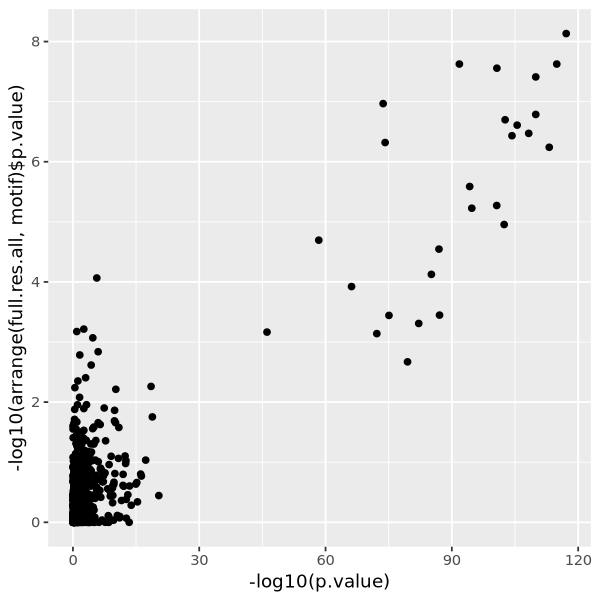

In [194]:
ggplot(arrange(full.res, motif), aes(x=-log10(p.value), y=-log10(arrange(full.res.all, motif)$p.value))) + geom_point()

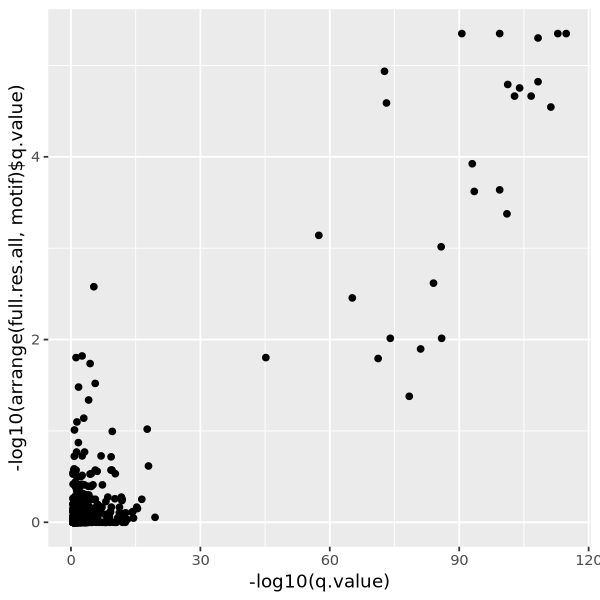

In [195]:
ggplot(arrange(full.res, motif), aes(x=-log10(q.value), y=-log10(arrange(full.res.all, motif)$q.value))) + geom_point()

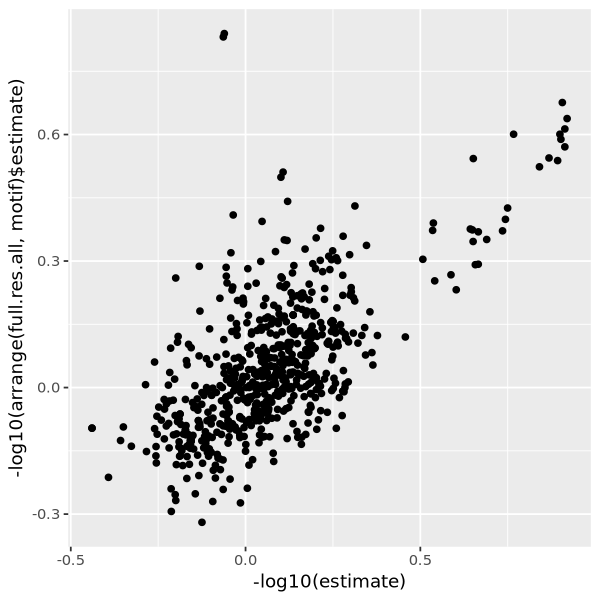

In [197]:
ggplot(arrange(full.res, motif), aes(x=-log10(estimate), y=-log10(arrange(full.res.all, motif)$estimate))) + geom_point()